# Assignment 1

**Handin**: *Friday*, March 11, 2022, 23:59<br>
The most important helper functions are copied from their original exercise sets but there are some you will have to copy by yourself. etc). Run the code so that the code produces outputs and plots. Once you're satisfied go ahead and upload it.

In [8]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pylab as plt
from scipy.interpolate import interp1d

### Week 1

In [9]:
# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        # Q1: Print these out for a network of size `[2, 3, 1]`, and explain their structure and contents
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        
        # Q2: What is `a`? How many iterations will this loop run? For a `sizes=[2, 3, 1]`
        # network, what is the shape of `a` at each iteration?
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    
    # --------------------------------------------------------------------------- #
    # Don't worry too much about the code below. We will look into that next week #
    # --------------------------------------------------------------------------- #
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  ``epochs`` represents the number of training iterations
        over the training data.  ``eta`` is the learning rate.
        If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        n = len(training_data)
        if test_data:
            n_test = len(test_data)
        
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.weights = [
            w - eta / len(mini_batch) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - eta / len(mini_batch) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return output_activations - y

Q1:
The first array printed out are the biases for the a network with layers with 2 neurons going into 3 neurons going into 1 neuron. So the first array within the biases array we printed shows the bias added for each neuron being passed through, which is why there are 3 elements for all 3 biases for that layer. Then for the next layer there is only one bias needed because there is only 1 element. Biases are an additional constant which help tweak the model for each neuron.

The second array printed out are the weights for the a network with layers with 2 neurons going into 3 neurons going into 1 neuron. The first array depicts the weights between the first layer with 2 neurons to the second layer with 3 neurons, where each row is the neuron in the second layer which the weight is pointing to, while the the columns is the neuron from which the weight is coming from. Therefore the numbers represent the weights from one neuron to another for every neuron in the 2 layers. This is the same for the next array as it has the weights from the second layer with 3 neurons to the the third layer with 1 neuron. Weights are essential as they are the treshold that change the values from the previous layers. 


Q2:
a is the summation of the regression + bias put through an activation function (sigmoid) for each each layer, which the gets used for the following layer, with the last layer being the final output. This loop will run twice since there are 2 layers after the first one. The shape of a is a sigmoid curve which makes it so a is smooth bounded between 0 and 1.

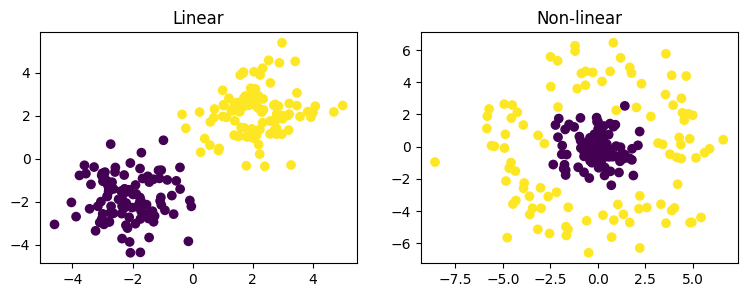

In [69]:
def generate_X_linear(N=200):
    X = np.vstack([
        np.random.normal([-2, -2], 1, size=(int(N/2), 2)),
        np.random.normal([2, 2], 1, size=(int(N/2), 2))
    ])

    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

def generate_X_nonlinear(N=200, R=5):
    X_inner = np.random.normal([0, 0], 1, size=(int(N/2), 2))

    X_outer = np.array([
        [R*np.cos(theta), R*np.sin(theta)]
        for theta in np.linspace(0, 2 * np.pi, int(N/2))
    ]) + np.random.randn(int(N/2), 2)

    X = np.vstack([X_inner, X_outer])
    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

plt.figure(figsize=(9, 3))

X, y = generate_X_linear()
plt.subplot(1, 2, 1)
plt.title("Linear", fontsize=12)
plt.scatter(X[:, 0], X[:, 1], c=list(y.reshape(-1)))

X, y = generate_X_nonlinear()
plt.subplot(1, 2, 2)
plt.title("Non-linear", fontsize=12)
plt.scatter(X[:, 0], X[:, 1], c=list(y.reshape(-1)))

The data needs to be formatted a little different when we give it to Nielsen's code. Basically, it asks for (x, y) tuple pairs, so in each tuple you have a datapoint and it's label. Furthermore, both x and y must be vertical vectors **(if you don't undertstand why, you didn't complete Ex. 1.2.1 properly)**.

The function below takes `X` and `y` and returns the data in this format:

In [11]:
def prepare_data(X, y):
    """Format the dataset X and y so it fits with Nielsen's code."""
    return [
        (X[i].reshape(-1, 1), y[i].reshape(-1, 1))  # our tuple (x, y)
        for i in range(len(y))
    ]

> **Ex. 1.2.2**: Create a neural network called `net` with `sizes=[2, 1]`. This is actually just the basic Perceptron with two inputs and a single output (or a logistic regression with two variables). Generate 1e5 training datapoints and 1e4 testing datapoints using the `generate_X_linear` function. Once you've done that run the code below to train the network and to get predictions for the test data.  

In [12]:
net = Network([2,1])
X, y = generate_X_linear(1e5)
training_data = prepare_data(X, y)
#print(training_data)
X_test, y_test = generate_X_linear(1e4)
test_data = prepare_data(X_test, y_test)
#print(test_data)

In [13]:
net.SGD(
    training_data,
    epochs=10,
    mini_batch_size=10,
    eta=1,
    test_data=test_data
)

# Get predictions
y_pred = []
for x in X_test:
    y_pred.append(net.feedforward(x.reshape(-1, 1))[0][0])

Epoch 0: 9975 / 10000
Epoch 1: 9976 / 10000
Epoch 2: 9976 / 10000
Epoch 3: 9977 / 10000
Epoch 4: 9976 / 10000
Epoch 5: 9976 / 10000
Epoch 6: 9977 / 10000
Epoch 7: 9976 / 10000
Epoch 8: 9976 / 10000
Epoch 9: 9976 / 10000


>Have a look at the predictions, e.g., print some of those values.  What do they look like? Are they just 0s and 1s? **Explain.**

In [14]:
print(y_pred[0])
print(y_pred[4499])

3.210885216852574e-06
1.3111975950429097e-06


They are floating point numbers between 0 and 1, which shows the amount of certainty in determining if the datapoint is a 0 or a 1.

>Once you've answered the question above, go ahead and run the code below to plot, side by side, the predictions versus the true labels.  **Comment on the differences.**

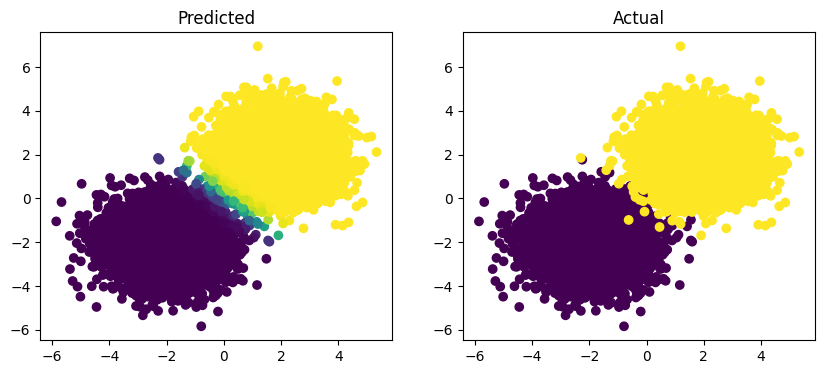

In [15]:
# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Predicted")
plt.scatter(X_test[:, 0], X_test[:, 1], c=list(y_pred))
plt.subplot(1, 2, 2)
plt.title("Actual")
plt.scatter(X_test[:, 0], X_test[:, 1], c=list(y_test.reshape(-1)))

We can see in the prediciton that it properly predicts the 2 groups of data, however it has less confidence of which data is in which group when in between the 2 datasets (where prediction would be around 0.5). It is not able to predict some of the outliers which overlap the other group.

> **Ex. 1.2.3**: Now we want to do the same thing as in Ex. 1.2.2, but with the data generated with the `generate_X_nonlinear` function. Comment on the result!
>
>*Hint: Think back to the lecture slides to figure out the size of the network you need in order to fit this kind of data.

In [16]:
net = Network([2,3,1])
X, y = generate_X_nonlinear(1e5)
training_data = prepare_data(X, y)
#print(training_data)
X_test, y_test = generate_X_nonlinear(1e4)
test_data = prepare_data(X_test, y_test)

net.SGD(
    training_data,
    epochs=10,
    mini_batch_size=10,
    eta=1,
    test_data=test_data
)

Epoch 0: 9744 / 10000
Epoch 1: 9803 / 10000
Epoch 2: 9783 / 10000
Epoch 3: 9784 / 10000
Epoch 4: 9796 / 10000
Epoch 5: 9816 / 10000
Epoch 6: 9789 / 10000
Epoch 7: 9815 / 10000
Epoch 8: 9781 / 10000
Epoch 9: 9787 / 10000


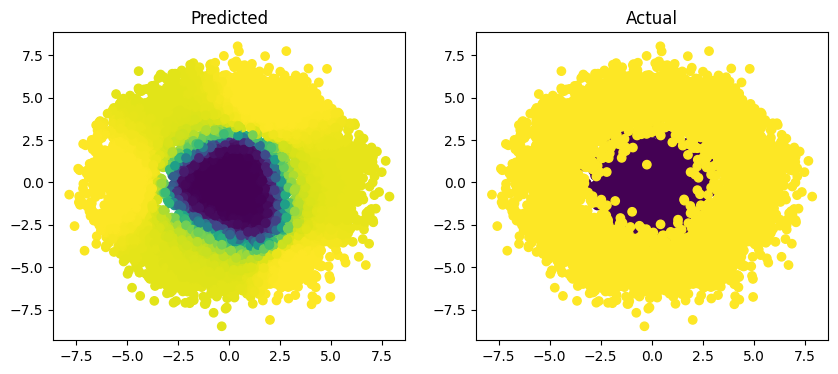

In [17]:
# Get predictions
y_pred = []
for x in X_test:
    y_pred.append(net.feedforward(x.reshape(-1, 1))[0][0])

plt.close()
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Predicted")
plt.scatter(X_test[:, 0], X_test[:, 1], c=list(y_pred))
plt.subplot(1, 2, 2)
plt.title("Actual")
plt.scatter(X_test[:, 0], X_test[:, 1], c=list(y_test.reshape(-1)))

The prediction is very confident for the outside cases and inside cases, but does have less confidence when it comes to the overlap. As you can see it also does not predict the outliers from the actual dataset.

### Week 2

![img](https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net.png)

> **Ex. 2.2.1**: The network above has a defined input and weights. If the true label for the datapoint `[4, 2]` is 1, what is the cost?


0.082

> **Ex. 2.2.2**: Knowing about backpropagation, we actually have everything we need to compute the gradients of the weights by hand. So go ahead and do that. Report your answer either as a diagram that includes the gradients (you can draw on my figure somehow and insert the resulting image), or just by writing what the gradient of each weight is.
>
> *Hint: When computing gradients with backprop, it can be a bit easier to think of the network as a computational graph. My computational graph looks like [this](https://github.com/abjer/tsds/blob/master/material_exercises/week_3/2_3_1_net_compgraph.png?raw=true).*
> *Hint: Some of the gradients will become VERY small (remember the vanishing gradient problem?). If they get smaller than 1e-4 you can just set them to zero.*

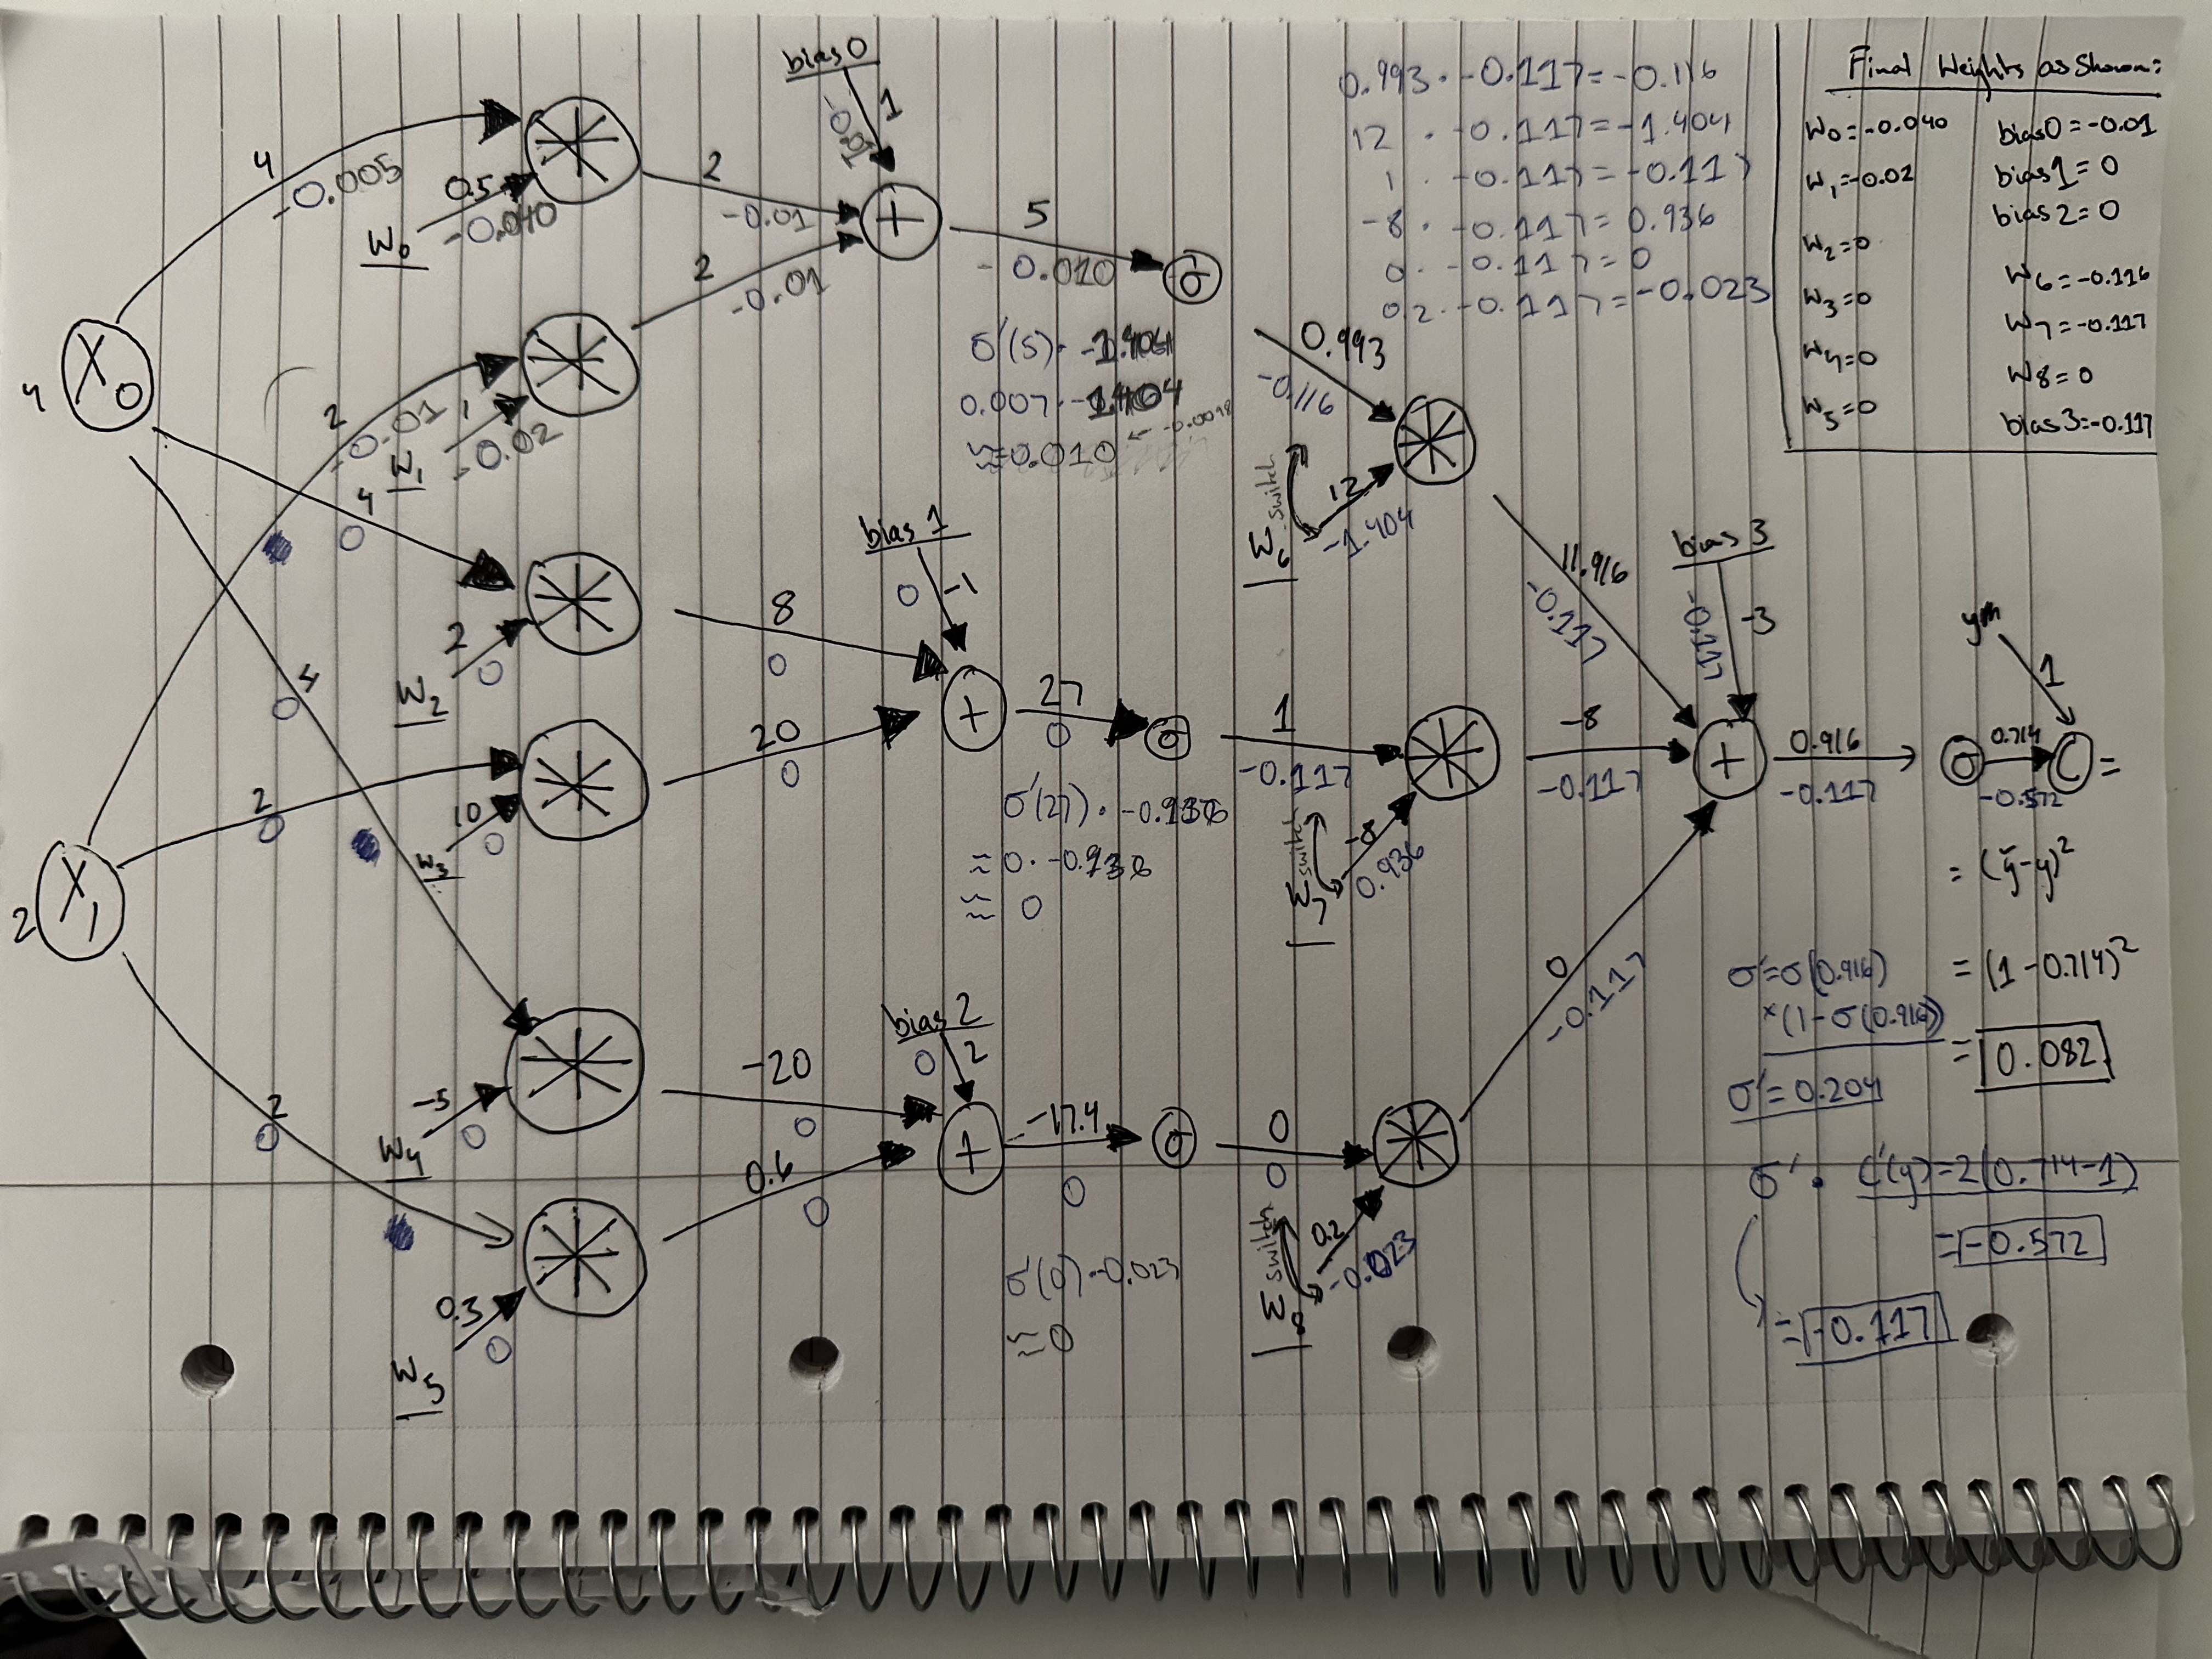

Final weights and biases are written in the top right corner in the picture above.

### Week 3

In [4]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist

> **Ex. 3.1.2** Solve exercises 1.2.2 and 1.2.3 from week 1, but solve them using Keras.
> Comment on differences in speed (and outcome if you observe any).

In [73]:
X, y = generate_X_linear(1e5)
X_test, y_test = generate_X_linear(1e4)

model = Sequential()
model.add(Dense(1, input_dim=2, activation = 'relu'))
batch_size = 200
epochs = 10

model.compile(loss="mse", optimizer="sgd", metrics=["accuracy"])

model.fit(X, y, batch_size=batch_size, epochs=epochs)

score = model.evaluate(X_test, y_test, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Epoch 1/10
500/500 [==============================] - 0s 367us/step - loss: 0.0859 - accuracy: 0.9226
Epoch 2/10
500/500 [==============================] - 0s 357us/step - loss: 0.0226 - accuracy: 0.9947
Epoch 3/10
500/500 [==============================] - 0s 353us/step - loss: 0.0219 - accuracy: 0.9964
Epoch 4/10
500/500 [==============================] - 0s 350us/step - loss: 0.0219 - accuracy: 0.9964
Epoch 5/10
500/500 [==============================] - 0s 360us/step - loss: 0.0219 - accuracy: 0.9964
Epoch 6/10
500/500 [==============================] - 0s 356us/step - loss: 0.0219 - accuracy: 0.9964
Epoch 7/10
500/500 [==============================] - 0s 351us/step - loss: 0.0219 - accuracy: 0.9964
Epoch 8/10
500/500 [==============================] - 0s 353us/step - loss: 0.0219 - accuracy: 0.9964
Epoch 9/10
500/500 [==============================] - 0s 353us/step - loss: 0.0219 - accuracy: 0.9964
Epoch 10/10
50/50 [==============================] - 0s 386us/step - loss: 0.0212 

In [72]:
X, y = generate_X_nonlinear(1e5)
X_test, y_test = generate_X_nonlinear(1e4)

model = Sequential()
model.add(Dense(9, input_dim=2, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))

batch_size = 200
epochs = 10

model.compile(loss="mse", optimizer="sgd", metrics=["accuracy"])

model.fit(X, y, batch_size=batch_size, epochs=epochs)

score = model.evaluate(X_test, y_test, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/10
500/500 [==============================] - 0s 395us/step - loss: 0.0885 - accuracy: 0.9403
Epoch 2/10
500/500 [==============================] - 0s 393us/step - loss: 0.0428 - accuracy: 0.9783
Epoch 3/10
500/500 [==============================] - 0s 382us/step - loss: 0.0416 - accuracy: 0.9790
Epoch 4/10
500/500 [==============================] - 0s 381us/step - loss: 0.0412 - accuracy: 0.9792
Epoch 5/10
500/500 [==============================] - 0s 384us/step - loss: 0.0408 - accuracy: 0.9795
Epoch 6/10
500/500 [==============================] - 0s 370us/step - loss: 0.0405 - accuracy: 0.9794
Epoch 7/10
500/500 [==============================] - 0s 378us/step - loss: 0.0403 - accuracy: 0.9798
Epoch 8/10
500/500 [==============================] - 0s 382us/step - loss: 0.0401 - accuracy: 0.9799
Epoch 9/10
500/500 [==============================] - 0s 377us/step - loss: 0.0399 - accuracy: 0.9801
Epoch 10/10
50/50 [==============================] - 0s 382us/step - loss: 0.0400 

Differences: The speed seems to be faster, even with more epochs, and accuracy is usually better although not always.

> **Ex. 3.2.1** To understand overfitting, we will intentionally overfit some data! Let's fit a neural network to the following data.  

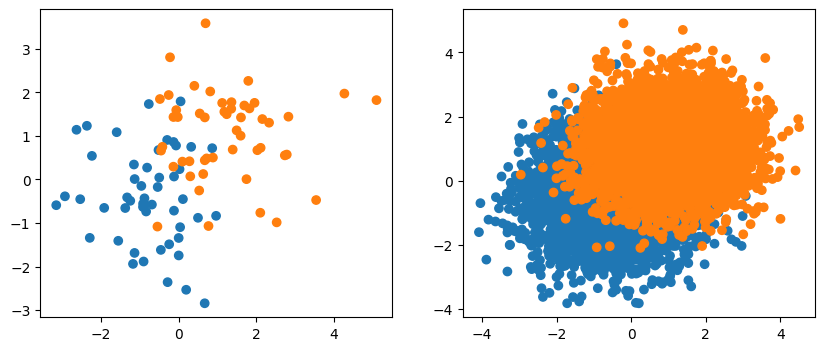

In [14]:
#code given in week1 exercise 1.2.2, slightly modified to have some crossover points
np.random.seed(2)
def generate_X_linear(N=200):
    X = np.vstack([
        np.random.normal([-0.5, -0.5], 1, size=(int(N/2), 2)),
        np.random.normal([1, 1], 1, size=(int(N/2), 2))
    ])

    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

ntr=100
nts=1e4
x_train, y_train = generate_X_linear(N=ntr)
x_test, y_test = generate_X_linear(N=nts)

fig,ax = plt.subplots(1,2, figsize=[10,4])
ax[0].scatter(x_train[:,0],x_train[:,1],color=['C'+str(i) for i in y_train.ravel()])
ax[1].scatter(x_test[:,0],x_test[:,1],color=['C'+str(i) for i in y_test.ravel()])

> The theoretical optimal decision boundary here is a straight line, and since the clusters are overlapping there should be some error when fitting the model to the data. Try to reduce the error to 0 anyway (accuracy = 1) by adding layers of ``overfitter.add(Dense(200, activation = 'relu'))`` to the code below

In [47]:
overfitter = Sequential()
overfitter.add(Dense(200, input_dim=2, activation = 'relu', kernel_regularizer=keras.regularizers.L2(0.05)))
overfitter.add(Dense(200, activation = 'relu', kernel_regularizer=keras.regularizers.L2(0.05)))
overfitter.add(Dense(200, activation = 'relu', kernel_regularizer=keras.regularizers.L2(0.05)))


overfitter.add(Dense(1, activation='sigmoid'))

overfitter.compile(optimizer='adam',
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy'])

# fit the model to the training data
history = overfitter.fit(x_train, y_train, epochs=300, batch_size=128)

Epoch 1/300
1/1 [==============================] - 0s 269ms/step - loss: 21.0933 - accuracy: 0.5000
Epoch 2/300
1/1 [==============================] - 0s 2ms/step - loss: 20.5863 - accuracy: 0.5400
Epoch 3/300
1/1 [==============================] - 0s 2ms/step - loss: 20.0900 - accuracy: 0.7900
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 19.6040 - accuracy: 0.8500
Epoch 5/300
1/1 [==============================] - 0s 2ms/step - loss: 19.1281 - accuracy: 0.8700
Epoch 6/300
1/1 [==============================] - 0s 3ms/step - loss: 18.6622 - accuracy: 0.8800
Epoch 7/300
1/1 [==============================] - 0s 2ms/step - loss: 18.2055 - accuracy: 0.8900
Epoch 8/300
1/1 [==============================] - 0s 3ms/step - loss: 17.7578 - accuracy: 0.8900
Epoch 9/300
1/1 [==============================] - 0s 3ms/step - loss: 17.3189 - accuracy: 0.8900
Epoch 10/300
1/1 [==============================] - 0s 2ms/step - loss: 16.8886 - accuracy: 0.8900
Epoch 11/300
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.4670 - accuracy: 0.8800
Epoch 168/300
1/1 [==============================] - 0s 3ms/step - loss: 0.4637 - accuracy: 0.8800
Epoch 169/300
1/1 [==============================] - 0s 3ms/step - loss: 0.4605 - accuracy: 0.8800
Epoch 170/300
1/1 [==============================] - 0s 3ms/step - loss: 0.4574 - accuracy: 0.8800
Epoch 171/300
1/1 [==============================] - 0s 3ms/step - loss: 0.4544 - accuracy: 0.8800
Epoch 172/300
1/1 [==============================] - 0s 3ms/step - loss: 0.4515 - accuracy: 0.8800
Epoch 173/300
1/1 [==============================] - 0s 2ms/step - loss: 0.4488 - accuracy: 0.8800
Epoch 174/300
1/1 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.8800
Epoch 175/300
1/1 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.8800
Epoch 176/300
1/1 [==============================] - 0s 2ms/step - loss: 0.4411 - accuracy: 0.8800
Epoch 177/300
1/1 [=====

> When you get acc=1, plot the test data and colour it using the predictions of your neural network

313/313 [==============================] - 0s 410us/step


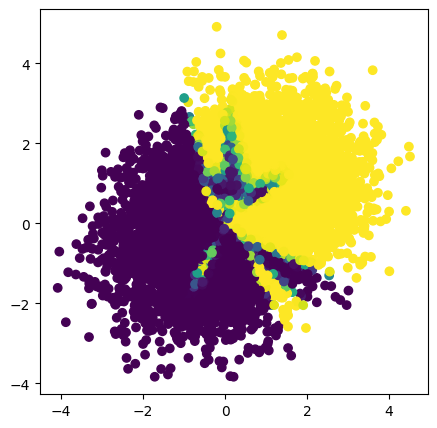

In [46]:
pred = overfitter.predict(x_test).ravel()
fig,ax = plt.subplots(1,1, figsize=[5,5])
ax.scatter(x_test[:,0],x_test[:,1],c=pred)

> Now add some L2 regularization ( ``... activation = 'relu', kernel_regularizer=l2(0.05)) `` ) into that same overfitting network in order to get a linear decision boundary. Plot the test data colour it using your predictions as before. Comment on the differences.

313/313 [==============================] - 0s 403us/step


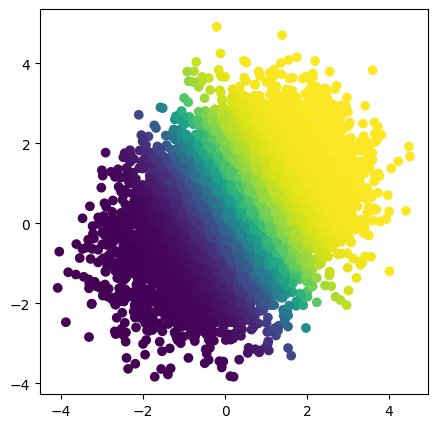

In [48]:
pred = overfitter.predict(x_test).ravel()
fig,ax = plt.subplots(1,1, figsize=[5,5])
ax.scatter(x_test[:,0],x_test[:,1],c=pred)

The model without the regularization is overfit and makes accuracy equal to 1, which is not what we want. The regularization helps stop the overfitting and slightly decreases the accuracy, creating a more viable model. Where the model is less confident in between the 2 groups.

### Week 4

> **Ex. 4.1.2**: You input an image of dimensions $28 \times 28 \times 3$, use a padding of 2, a stride of 1,
and then slide your $5 \times 5 \times 3$ filter across the image. What is the dimensionality of the resulting activation map?

W = (N +2P - F) / S + 1

W = 28

28x28x1

> **Ex. 4.1.3**: Let's say you now want to use a stride of 2, instead of 1. What problem does this immediately cause?
How can we solve it?

We now have a floating point value for the width (14.5) which is an integer where the kernel will not properly be able to go cover it, which we can solve by changing the filter size to be even.

> **Ex. 4.1.5**: Implement Nielsen's [convolutional neural networks](http://neuralnetworksanddeeplearning.com/chap6.html#exercise_683491)
(for this assignment only include the last network from the textbook, the one with 2 convolutional layers and dropout), and score an accuracy higher than 98%. The implementations don't have to be
fully identical, but his solutions are pretty great, so getting close is a cheap way to score a high accuracy.


In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape data so it has a channel dimension
rows, cols = x_train.shape[-2:]
x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)

# Convert pixel intensities to values between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
    
# Convert target vectors to one-hot encoding
num_classes = len(set(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
model = keras.Sequential(
    [
        keras.Input(shape = (28,28,1)),
        Conv2D(1, kernel_size=(3, 3), activation="relu"),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

In [9]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15


2023-02-28 10:11:23.802299: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


422/422 [==============================] - 6s 13ms/step - loss: 0.5083 - accuracy: 0.8562 - val_loss: 0.2147 - val_accuracy: 0.9382
Epoch 2/15
422/422 [==============================] - 6s 13ms/step - loss: 0.2271 - accuracy: 0.9336 - val_loss: 0.1254 - val_accuracy: 0.9683
Epoch 3/15
422/422 [==============================] - 6s 13ms/step - loss: 0.1482 - accuracy: 0.9567 - val_loss: 0.0877 - val_accuracy: 0.9777
Epoch 4/15
422/422 [==============================] - 5s 13ms/step - loss: 0.1139 - accuracy: 0.9660 - val_loss: 0.0754 - val_accuracy: 0.9792
Epoch 5/15
422/422 [==============================] - 5s 13ms/step - loss: 0.0971 - accuracy: 0.9706 - val_loss: 0.0679 - val_accuracy: 0.9805
Epoch 6/15
422/422 [==============================] - 6s 13ms/step - loss: 0.0852 - accuracy: 0.9739 - val_loss: 0.0655 - val_accuracy: 0.9833
Epoch 7/15
422/422 [==============================] - 5s 13ms/step - loss: 0.0760 - accuracy: 0.9762 - val_loss: 0.0608 - val_accuracy: 0.9832
Epoch 8/15

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.048570387065410614
Test accuracy: 0.9851999878883362
